In [1]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.0 MB/s eta 0:00:00


In [2]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [3]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 4
CLASSES = [1, 2, 3, 4]
PALETTE = ['87CEFA', 'D2B48C', 'F08080', '006400']
SAMPLE_PATH = '/content/drive/MyDrive/DL/Samples_Mangaluru_2000.csv'


In [5]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
889,0.072112,0.085752,0.093205,0.099200,0.041532,0.027397,0.013411,0.567172,0.409767,-0.072708,-0.409767,0.205063,1,1,train
2558,0.066172,0.083112,0.064247,0.059930,0.035263,0.024895,-0.011372,0.413027,0.259133,0.162067,-0.259133,0.172339,0,1,train
176,0.061222,0.083140,0.072800,0.053275,0.033612,0.021952,-0.047349,0.416370,0.226298,0.218928,-0.226298,0.209844,1,1,train
4197,0.032265,0.053137,0.049260,0.260487,0.177080,0.083030,0.401860,0.516589,0.190616,-0.661140,-0.190616,0.361578,40,2,train
4309,0.047129,0.074051,0.095171,0.183006,0.290971,0.193580,0.156785,-0.028078,-0.227785,-0.423855,0.227785,0.200993,100,2,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5069,0.064687,0.087045,0.108165,0.180366,0.209585,0.155658,0.134283,0.073533,-0.074929,-0.348980,0.074929,0.147648,15,3,train
5752,0.044393,0.069005,0.074010,0.186567,0.199960,0.113967,0.216843,0.241569,-0.034648,-0.459997,0.034648,0.273925,13,3,train
1653,0.043320,0.071645,0.077530,0.077668,0.046840,0.025060,0.000282,0.512107,0.247596,-0.040335,-0.247596,0.302921,1,1,train
6391,0.046593,0.064028,0.060480,0.205735,0.134978,0.061883,0.297856,0.537530,0.207675,-0.525305,-0.207675,0.371304,9,3,test


<ipython-input-6-60f1ee59be04>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(samples, x='B1', y='sample', inner='box', palette='Dark2')


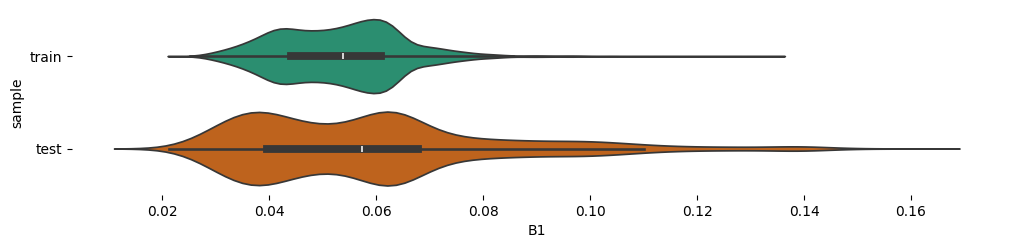

In [6]:
# @title sample vs B1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(samples['sample'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(samples, x='B1', y='sample', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

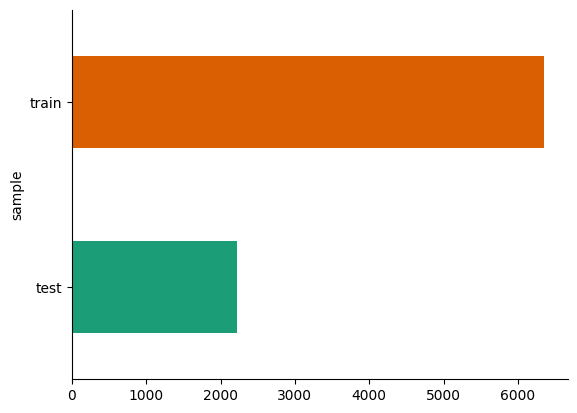

In [7]:
# @title sample

from matplotlib import pyplot as plt
import seaborn as sns
samples.groupby('sample').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

TypeError: to_categorical() takes from 1 to 2 positional arguments but 3 were given

In [9]:
!pip install tensorflow

import tensorflow as tf

# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1) # Use tf.keras.utils.to_categorical with num_classes argument
test_output = tf.keras.utils.to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1) # Use tf.keras.utils.to_categorical with num_classes argument

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (6352, 13, 1)
Test features: (2221, 13, 1)
Train label: (6352, 5)
Test label: (2221, 5)


In [10]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 1024
drop = 0.66
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),

  GlobalMaxPooling1D(),

  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 12, 1024)            │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 1024)            │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 4, 2048)             │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 2048)             │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,987,909 (80.06 MB)

 Trainable params: 20,987,909 (80.06 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=9
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=49,
)

Epoch 1/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.3437 - loss: 1.6219 - val_accuracy: 0.3336 - val_loss: 1.4863
Epoch 2/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.3217 - loss: 1.4012 - val_accuracy: 0.3381 - val_loss: 1.2127
Epoch 3/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6086 - loss: 0.9178 - val_accuracy: 0.5979 - val_loss: 0.9412
Epoch 4/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7318 - loss: 0.7079 - val_accuracy: 0.6502 - val_loss: 0.8994
Epoch 5/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7414 - loss: 0.6664 - val_accuracy: 0.6506 - val_loss: 0.8106
Epoch 6/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7702 - loss: 0.6146 - val_accuracy: 0.6637 - val_loss: 0.7629
Epoch 7/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7799 - loss: 0.5888 - val_accuracy: 0.6988 - val_loss: 0.7320
Epoch 8/49
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7817 - loss: 0.5728 - val_accuracy: 0.6965 - val_loss: 

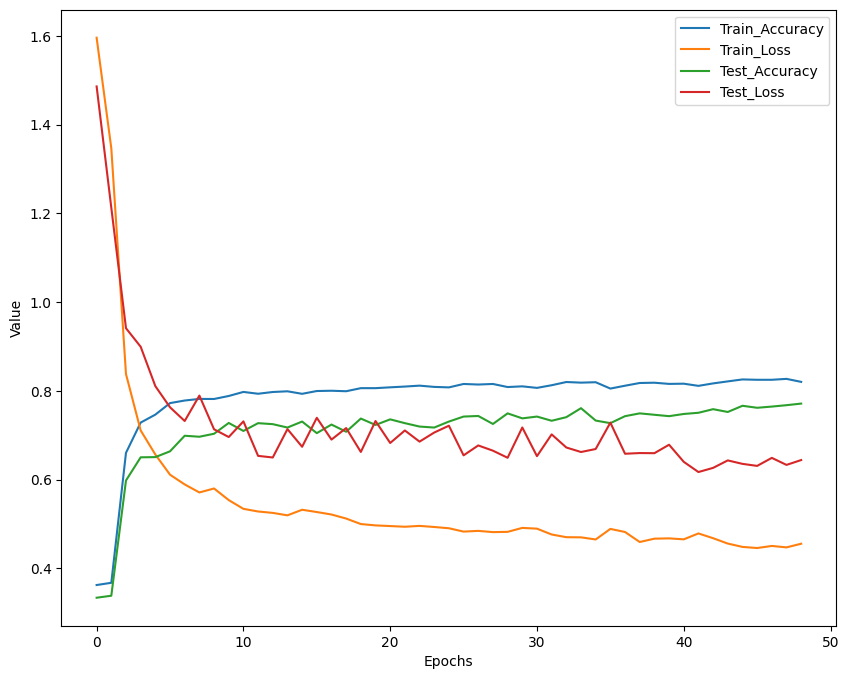

In [12]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           1       0.83      0.98      0.90       751
           2       0.74      0.24      0.36       141
           3       0.76      0.53      0.62       741
           4       0.71      0.94      0.81       588

    accuracy                           0.77      2221
   macro avg       0.76      0.67      0.67      2221
weighted avg       0.77      0.77      0.75      2221



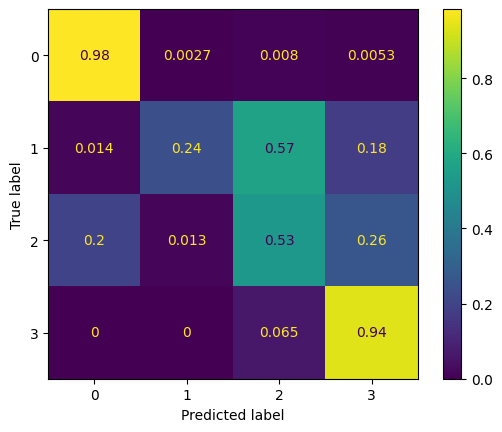

In [13]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [14]:
# Save model
model.save('/content/drive/MyDrive/DL/L5L7LULC.h5')

# Save model
model.save('L5L7LULC.h5')
model.save('L5L7LULC.keras')
# Download to local system
from google.colab import files
files.download('L5L7LULC.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
IMAGE00_PATH = '/content/drive/MyDrive/DL/Landsat_Mangaluru_2000.tif'

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


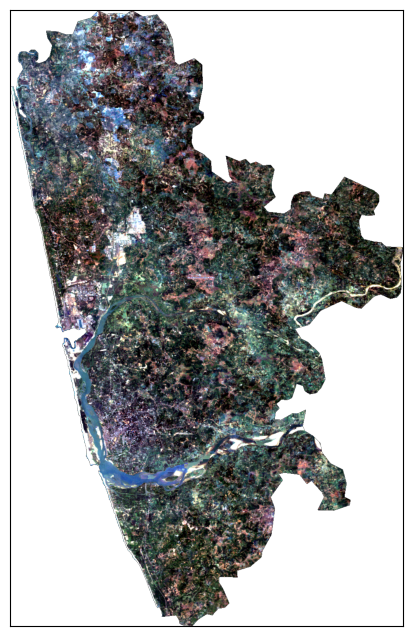

<Axes: >

In [16]:
# Load image
image = rasterio.open(IMAGE00_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [3, 2, 1]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

61/61 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step


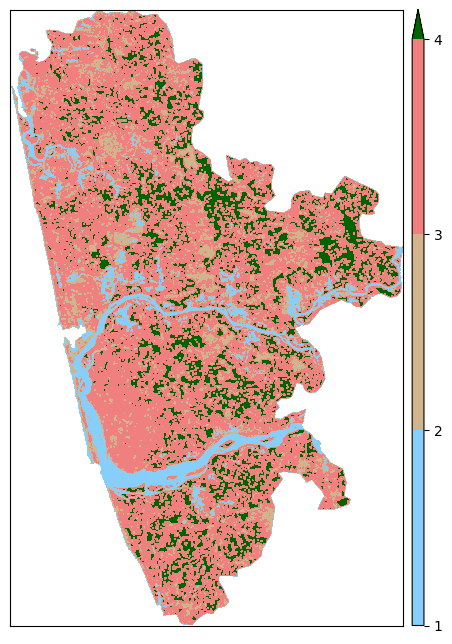

<Axes: >

In [17]:
# Predict image using the model

image_input = []
for x in range(13):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(13, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=1024*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

import matplotlib.colors as mcolors

# Normalize hexadecimal color values to RGBA
PALETTE_normalized = [mcolors.hex2color('#' + color) for color in PALETTE]

# Visualization
cmap, norm = mcolors.from_levels_and_colors(CLASSES, PALETTE_normalized, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)


In [ ]:
import rasterio

# Define the save location and filename
save_location = '/content/drive/MyDrive/DL/'
name = 'l5_Mangaluru_2000_CNN.tif'
location = save_location + name

# Specify CRS as EPSG:4326 (WGS 84)
crs = 'EPSG:4326'

# Open a new GeoTIFF file in write mode
with rasterio.open(
    location,
    mode='w',
    driver='GTiff',
    height=prediction.shape[0],
    width=prediction.shape[1],
    count=1,  # Number of bands
    dtype='float32',  # Specify float32 data type
    crs=crs,  # Specify CRS
    transform=transform  # Affine transform
) as new_dataset:
    # Write the predicted values to the GeoTIFF file
    new_dataset.write(prediction.astype('float32'), 1)
